# Preamble

In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from utils.my_units import *
from superrad import ultralight_boson as ub

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
fontsize = 14
rcParams.update({'font.size':fontsize})

# Number of events per unit strain

## Some tests

In [3]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [4]:
mbh = 10
abh0 = 0.5
alpha = 0.02

wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")

if wf.azimuthal_num()==1:
    tauGW = wf.gw_time()*Second

In [5]:
tauSR = wf.cloud_growth_time()
tauGW = wf.gw_time()
tauSR/1E9, tauGW/1e13

(4.345572030927802, 2.84590924589311)

In [6]:
wf.strain_char(-10, dObs=0.001) # distance in Mpc

4.5728003476743694e-24

In [7]:
wf.strain_char(-1E9, dObs=0.001)

6.532471187190322e-42

In [8]:
tList = np.geomspace(1E-5,1E7,100)*tauGW #np.concatenate([ np.sort(np.logspace(-9,0,50)*(-tauSR)), np.logspace(-13, 2, 200)*tauGW ] )  
hList = wf.strain_char(tList, dObs=0.001)

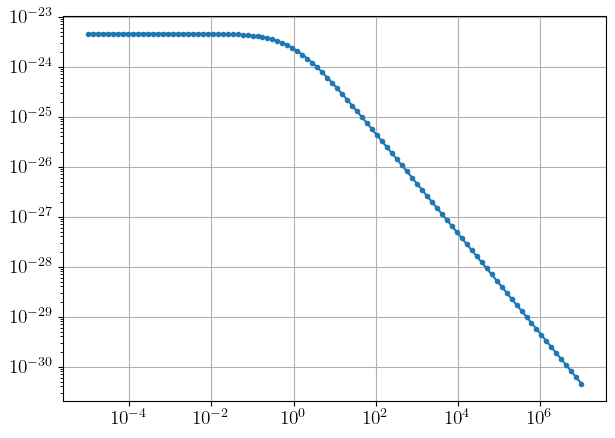

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']

#ax.plot((tList+tauSR)[1:], hList[1:])
ax.plot(tList/tauGW, hList, marker='.')
ax.set_xscale('log'); ax.set_yscale('log')
ax.grid()

## Get the distribution

In [9]:
# Black hole mass distribution from 2003.03359
Mmin, Mmax = 5, 30
Norm = 0.740741*(Mmax**(1.35)-Mmin**(1.35))/( (Mmax*Mmin)**(1.35))

def dndM(m):
    return 1/Norm*1/m**(2.35)

In [10]:
# Grid of values of M, a and t
MList = np.geomspace(Mmin, Mmax, 100) #np.arange(Mmin, Mmax, 0.2)
aList = np.linspace(0, 1, 100)
tSteps = 500
#tList = np.geomspace(1E-5,1E7,100)

np.trapz(dndM(MList), x=MList)

1.0002145481580622

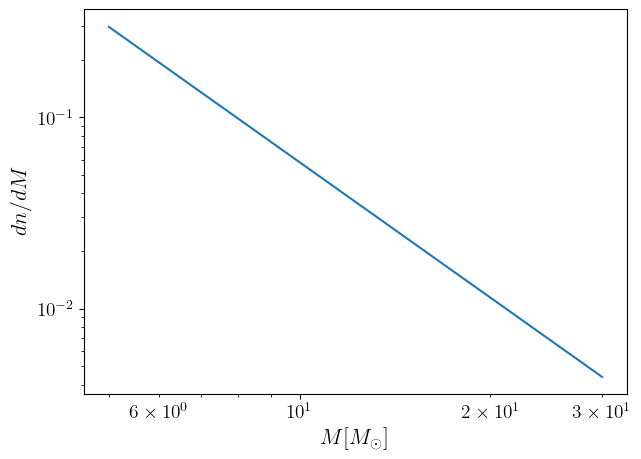

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

ax.plot(MList, dndM(MList))
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$M [M_{\odot}]$', fontsize=font_s)
ax.set_ylabel(r'$dn/dM$', fontsize=font_s);

In [13]:
bc = ub.UltralightBoson(spin=1, model="relativistic") 

In [81]:
freq_GW = 200
mu = np.pi*freq_GW*Hz
RMW = 20*kpc
tMW = 13.6*1E9*Year

hTilde = np.zeros((len(MList), len(aList), tSteps))
tGrid = np.zeros((len(MList), len(aList), tSteps))
fMList = dndM(MList)
                   
for i_m, mbh in enumerate(tqdm(MList)):
    #print('Mass = ', mbh, '\n')         
    alpha = GN*mu*mbh*MSolar
    
    for i_a, abh0 in enumerate(aList):
        try:
            wf = bc.make_waveform(mbh, abh0, alpha, units="physical+alpha")
            if wf.azimuthal_num()==1:
                tauGW = wf.gw_time() 
                tauSR = wf.cloud_growth_time() 
                
                tTildeMin = tauGW*Second/tMW*1E-4
                tTildeMax = 1-tauSR*Second/tMW    
                tListTemp = np.concatenate([[0], np.geomspace(tTildeMin,tTildeMax,tSteps-1)])
                tGrid[i_m, i_a, :] = tListTemp
                
                hTilde[i_m, i_a, :] = wf.strain_char(tListTemp*tMW/Second, dObs=(RMW/Mpc) )
                
        except ValueError:
            #print(abh0, ' spin not working')
            pass #break

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


In [82]:
tTildeMax, tauGW*Second/tMW

(0.9999999999994565, 1.3094416693379773e-11)

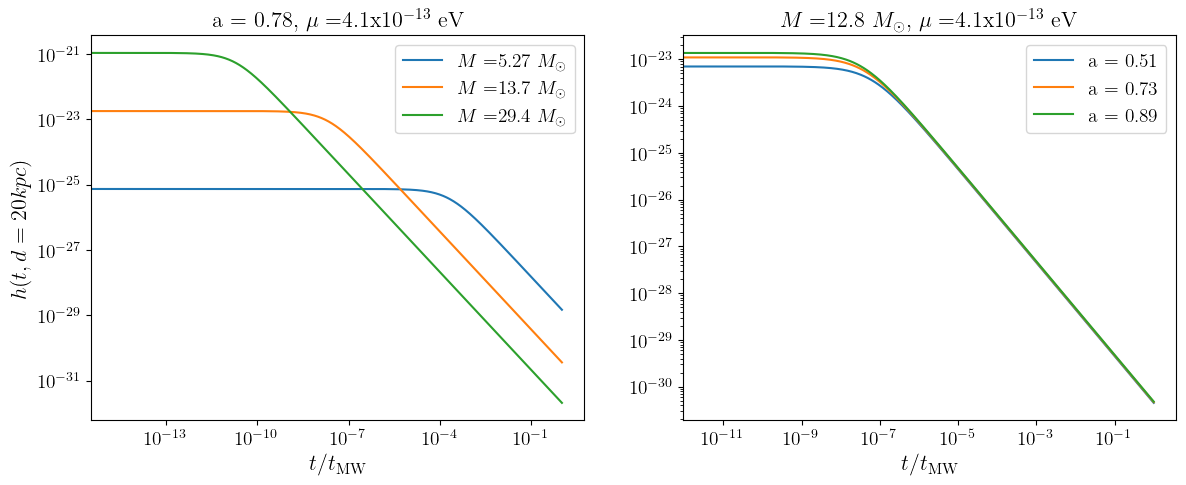

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
sub_im = np.array([3, 56, 98])
i_a = 78

for i in sub_im:
    ax[0].plot(tGrid[i, i_a, :], hTilde[i, i_a, :], label=r'$M = $'+str(MList[i])[:4]+'$\ M_{\odot}$')
    
i_m = 52
sub_ia = np.array([51, 73, 89])

for i in sub_ia:
    ax[1].plot(tGrid[i_m, i, :], hTilde[i_m, i, :], label=r'a = '+str(aList[i])[:4])

ax[0].set_title(r'a = '+str(aList[i_a])[:4]+', $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);
ax[1].set_title(r'$M = $'+str(MList[i_m])[:4]+'$\ M_{\odot}$, $\mu = $'+str(mu/eV/1e-13)[:3]+'x$10^{-13}$ eV', fontsize=font_s);

for i in range(2):
    ax[i].set_xscale('log'); ax[i].set_yscale('log')
    ax[i].set_xlabel(r'$t/t_{\mathrm{MW}}$', fontsize=font_s)
    ax[0].set_ylabel(r'$h(t, d=20 kpc)$', fontsize=font_s);
    ax[i].legend()

In [84]:
hList = np.geomspace(1E-28, 1E-24, 500)
dfdlogh = np.zeros(hList.shape)

In [85]:
for i_h, hVal in enumerate(tqdm(hList)):    
    
    thFnc = np.heaviside((hVal/hTilde-1), np.zeros(hTilde.shape))
    integrand = ( (hTilde/hVal) )**3*thFnc
    
    intOvert = np.trapz(integrand, x=tGrid, axis=2)
    intOvera = np.trapz(intOvert, x=aList, axis=1)
    dfdlogh[i_h] = 3*np.trapz(fMList*intOvera, x=MList)

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-85-04b283db971c>:3: RuntimeWarning: divide by zero encountered in divide
  thFnc = np.heaviside((hVal/hTilde-1), np.zeros(hTilde.shape))
100%|██████████| 500/500 [00:55<00:00,  9.06it/s]


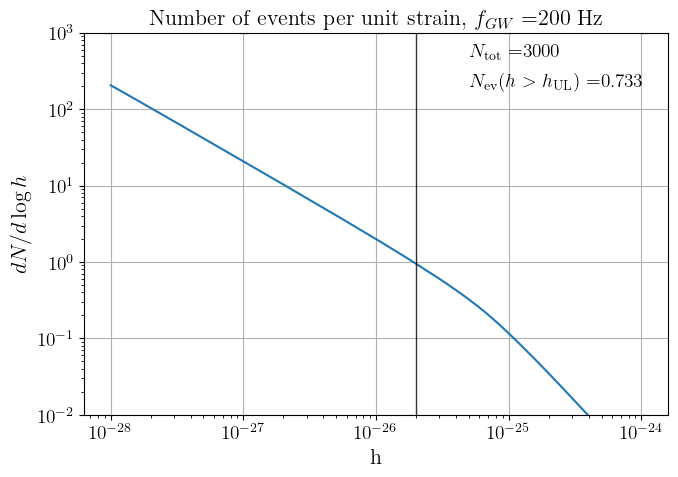

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
hUL = 2E-26

Ntot = 3000

selh = (hList > hUL)
Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

ax.plot(hList, Ntot*dfdlogh)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $f_{GW} = $'+str(freq_GW)+' Hz', fontsize=font_s);
ax.text(5E-26, 5E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
ax.text(5E-26, 2E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.8)
ax.set_ylim(0.01,1000)
ax.grid()

fig.tight_layout()
#fig.savefig('figs/dndlogh.pdf', bbox_inches="tight")

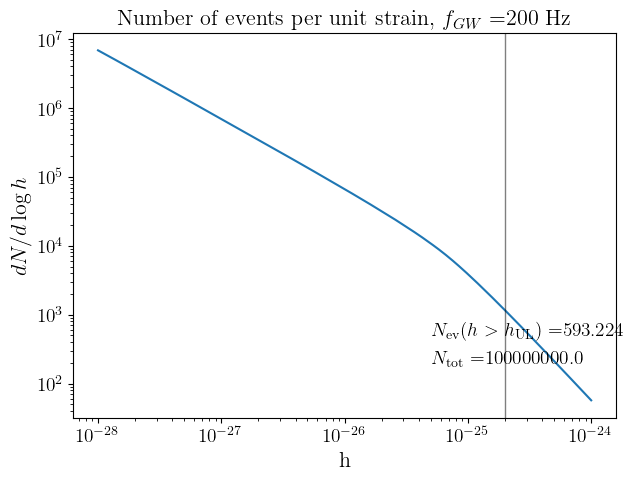

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16
hUL = 2E-25

Ntot = 1E8

selh = (hList > hUL)
Nev = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

ax.plot(hList, Ntot*dfdlogh)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'h', fontsize=font_s); ax.set_ylabel(r'$dN/d\log h$', fontsize=font_s); 
ax.set_title('Number of events per unit strain, $f_{GW} = $'+str(freq_GW)+' Hz', fontsize=font_s);
ax.text(5E-26, 5E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
ax.text(5E-26, 2E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.5)

In [88]:
hUL_list = np.geomspace(1E-27, 1E-24, 100)

Nev_List = np.zeros(len(hUL_list))
Ntot = 3000

for i, hUL in enumerate(hUL_list):
    selh = (hList > hUL)
    Nev_List[i] = Ntot*np.trapz(dfdlogh[selh]/hList[selh], x=hList[selh])

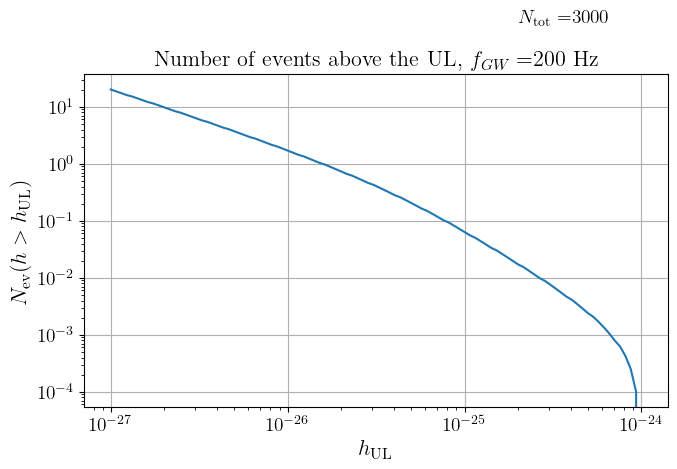

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
colorlist =  ['darkslateblue', 'darkred', 'orangered', 'green'] #['teal', 'orange', 'indianred']
liestyle_list = ['solid', 'dashed', 'dashdot']
font_s=16

#ax.plot(hUL_list, Nev_List, marker='.')
ax.plot(hUL_list, Nev_List)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$h_{\mathrm{UL}}$', fontsize=font_s); ax.set_ylabel(r'$N_{\mathrm{ev}}(h>h_{\mathrm{UL}})$', fontsize=font_s); 
ax.set_title('Number of events above the UL, $f_{GW} = $'+str(freq_GW)+' Hz', fontsize=font_s);
ax.text(2E-25, 3E2, r'$N_{\mathrm{tot}} =$'+str(Ntot))
#ax.text(5E-26, 2E2, r'$N_{\mathrm{ev}}(h > h_{\mathrm{UL}}) =$'+str(round(Nev, 3)))
#ax.axvline(x=hUL, linewidth=1, c='k', alpha=0.5)
#ax.set_ylim(0.1,2000)
ax.grid()

fig.tight_layout()
fig.savefig('figs/NaboveUL.pdf', bbox_inches="tight")